# Multi-layer Neural Networks

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

## 데이터 로드 및 전처리

In [2]:
# Boston house price data 불러오기
from sklearn.datasets import load_boston

boston = load_boston()

In [3]:
# 데이터를 label과 feature로 나누고 data frame으로 불러옵니다.
features_df = pd.DataFrame(np.array(boston.data), columns=[boston.feature_names])

# 데이터의 상단 5개를 출력합니다.
features_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


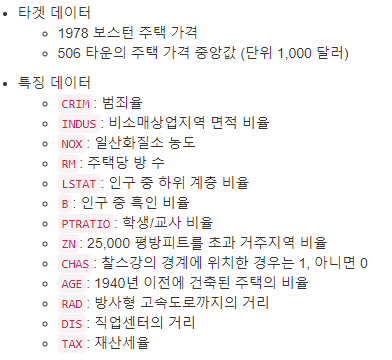

In [4]:
# Labels
labels_df = pd.DataFrame(np.array(boston.target), columns=['PRICE'])
labels_df.head()

,PRICE
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [5]:
# 데이터를 트레이닝 / 테스트 셋으로 분리 하기 위한 모듈
from sklearn.model_selection import train_test_split

In [6]:
# 데이터를 트레이닝 / 테스트 셋으로 분리
# Training Data = 80% of Dataset
# Test Data = 20% of Dataset
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=101)

In [7]:
# Normalize Data
from sklearn.preprocessing import StandardScaler

In [8]:
# Define the Preprocessing Method and Fit Training Data to it
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [9]:
# Make X_train to be the Scaled Version of Data
# This process scales all the values in all 6 columns and replaces them with the new values
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

In [10]:
# Converting from Pandas Dataframe to Numpy Arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
# Get the Type of Training Data
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [12]:
# Apply same Normalization for Test Features
scal = StandardScaler()
scal.fit(X_test)

StandardScaler()

In [13]:
# Make X_test to be the Scaled Version of Data
# This process scales all the values in all columns and replaces them with the new values
X_test = pd.DataFrame(data=scal.transform(X_test), columns=X_test.columns, index=X_test.index)

In [14]:
# Convert test features and Labels to Numpy Arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
# Get the Type of Test Data
type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray)

## 모델 설계

In [16]:
# Parameters
learning_rate = 0.1
num_epoch = 1000

# Network Parameters
n_hidden_1 = 64 # 1st layer number of neurons
n_hidden_2 = 64 # 2nd layer number of neurons
num_input = 13 # number of X data 
num_output = 1 # house price

In [17]:
from tensorflow.keras import Model, layers

# tf.keras.Model을 상속하여 모델 설계
class NNModel(Model):
    def __init__(self):
        super().__init__()
        self.dense1 = layers.Dense(n_hidden_1, activation="sigmoid", input_shape=(num_input,))
        self.dense2 = layers.Dense(n_hidden_2, activation="sigmoid")
        self.dense3 = layers.Dense(num_output)
    
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

model = NNModel()
model.build((None,num_input))

# 다른 방법으로, tf.keras.Sequential()함수를 사용하여 간결하게 설계할 수 있음.

model2 = tf.keras.Sequential()
model2.add(layers.InputLayer((num_input,)))
model2.add(layers.Dense(n_hidden_1, activation="sigmoid"))
model2.add(layers.Dense(n_hidden_2, activation="sigmoid"))
model2.add(layers.Dense(num_output))

model3 = tf.keras.Sequential(
    [
        layers.InputLayer((num_input,)),
        layers.Dense(n_hidden_1, activation="sigmoid"),
        layers.Dense(n_hidden_2, activation="sigmoid"),
        layers.Dense(num_output)
    ]
)

# 세 모형은 같음
model.summary()
model2.summary()
model3.summary()

Model: "nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  896       
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
____________________________________

In [18]:
# 최적화 목표함수로 Mean Squared Error (평균제곱오차) 사용
loss_object = tf.keras.losses.MeanSquaredError()

# 최적화 알고리즘 선택
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate)
optimizer_rmsprop = tf.keras.optimizers.RMSprop(learning_rate)
optimizer_adam = tf.keras.optimizers.Adam(learning_rate)

optimizer = optimizer_sgd  # 선택하여 적용하면됨!

In [19]:
# 모델 학습과정 중 loss 계산 

train_loss = tf.keras.metrics.Mean(name='train_loss')

## 모델 학습

In [20]:
@tf.function
def train_step(xs, ys):
    with tf.GradientTape() as tape:
        # 모형에 데이터를 넣어서 예측 값을 얻음
        predictions = model(xs, training=True)
        
        # 최적화 목표함수를 기준으로 예측 값을 평가 (loss를 구함)
        loss = loss_object(ys, predictions)
        
    # loss를 최소화하는 기울기(gradient)를 계산함.
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # 기울기를 바탕으로 모형 파라미터를 수정함
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)

In [21]:
loss_history = []

for epoch in range(num_epoch):
    # Run optimization op (backprop)
    
    train_step(X_train.astype(np.float32), y_train.astype(np.float32))
    loss_history.append(train_loss.result())
    if epoch % 100 == 0:
        # Calculate batch loss and accuracy
        print("Step " + str(epoch) + ", Loss= " + "{:.4f}".format(train_loss.result().numpy().item()))

print("Optimization Finished!")

Step 0, Loss= 552.9567
Step 100, Loss= 121.0506
Step 200, Loss= 66.1742
Step 300, Loss= 47.1419
Step 400, Loss= 37.3897
Step 500, Loss= 31.4354
Step 600, Loss= 27.3847
Step 700, Loss= 24.4279
Step 800, Loss= 22.1494
Step 900, Loss= 20.2617
Optimization Finished!


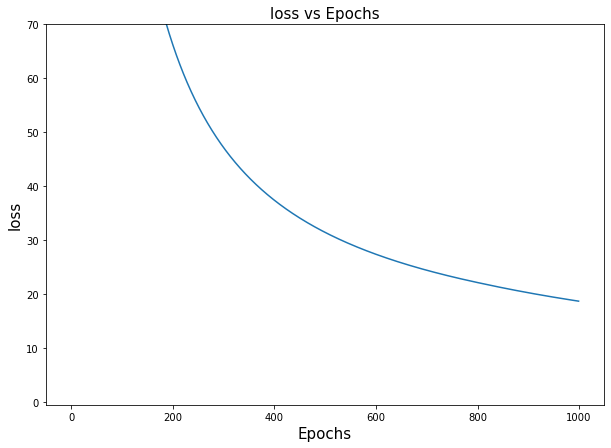

In [22]:
# training epoch에 따른 loss

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(loss_history)
# plt.axis([0,epoch,0,np.max(loss_history)])
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.title('loss vs Epochs', fontsize=15)
ax.set_ylim([-0.5, 70])
plt.show()

## 실제 값과 예측 값 비교

In [23]:
# 테스트 데이터 X값을 모델에 넣어서 예측 결과(예측 Y값)를 얻음
y_pred = model(X_test, training=False)
y_pred = y_pred.numpy()
y_pred.reshape(-1)

array([43.544327 , 27.205702 , 13.484333 , 19.020805 , 27.446331 ,
       33.09836  , 44.346207 , 13.849798 , 36.375847 , 10.817003 ,
       25.129662 , 17.167713 , 20.55468  , 20.273045 , 21.519005 ,
       34.5216   , 11.851815 , 30.525023 , 26.578041 , 23.665245 ,
       12.865544 , 20.43338  , 20.300385 , 28.0483   , 32.950188 ,
       21.301054 , 26.890827 , 20.000187 , 31.886404 , 31.03302  ,
       20.84783  , 20.076908 , 36.27308  , 37.73053  , 26.652016 ,
       22.536564 , 13.03193  , 18.863476 , 11.109656 , 26.771389 ,
       23.696999 , 22.04764  , 39.93148  , 14.212736 , 20.917286 ,
       21.068687 , 27.801636 , 19.300858 , 24.478743 , 26.022852 ,
       35.19639  , 56.23529  , 21.52279  , 21.160826 , 29.56401  ,
       10.752253 , 20.515574 , 19.62355  , 23.88365  , 20.833761 ,
       32.069786 , 10.830498 , 23.496801 , 23.804745 , 12.263586 ,
       21.892286 , 23.181532 , 20.41258  , 13.124245 , 20.073168 ,
       20.44381  , 24.60964  , 19.185078 , 20.213715 , 25.0358

In [24]:
# 테스트 데이터 실제 결과 Y값
y_test.reshape(-1)

array([50. , 36.2, 11.7, 14.9, 30.8, 36.1, 50. , 13.2, 41.3,  8.5, 23.5,
       13.3, 20.2, 18.6, 18.5, 27.9, 10.4, 28.5, 28.4, 23.1, 12.8, 21.7,
       11.9, 29.6, 37.3, 19.9, 29. , 18. , 50. , 34.6, 24.3, 18.2, 44. ,
       50. , 30.7, 22.6, 14.1, 14.5,  8.4, 32.5, 24.3, 20.6, 43.8, 11.5,
       19.9, 23.8, 28.7, 17.8, 23.9, 33. , 31.5, 21.9, 17.4, 15. , 34.7,
       13.8, 20.4, 19.5, 22.4, 16.8, 32.9, 14.4, 27.5, 20.1,  8.3, 27.5,
       25. , 17.1, 10.9, 18.5, 19.2, 20.7, 17. , 19.2, 27.1, 15.6, 50. ,
       14.4, 22.8,  7.2, 15.6, 19.5, 29.4, 15.4, 16.5, 19.8, 21.4, 32. ,
       24.7, 16.1, 11.3, 15.6, 25. , 31. ,  5. , 50. , 14.6, 31.6,  5. ,
       20.9, 31.7, 20.1])

In [25]:
# 예측 Y값과 실제 Y값 간의 오차를 구함 (평균제곱오차) Mean Squared Error
mse = loss_object(y_test, y_pred).numpy()
print('Mean Squared Error: ',mse)

Mean Squared Error:  29.754028


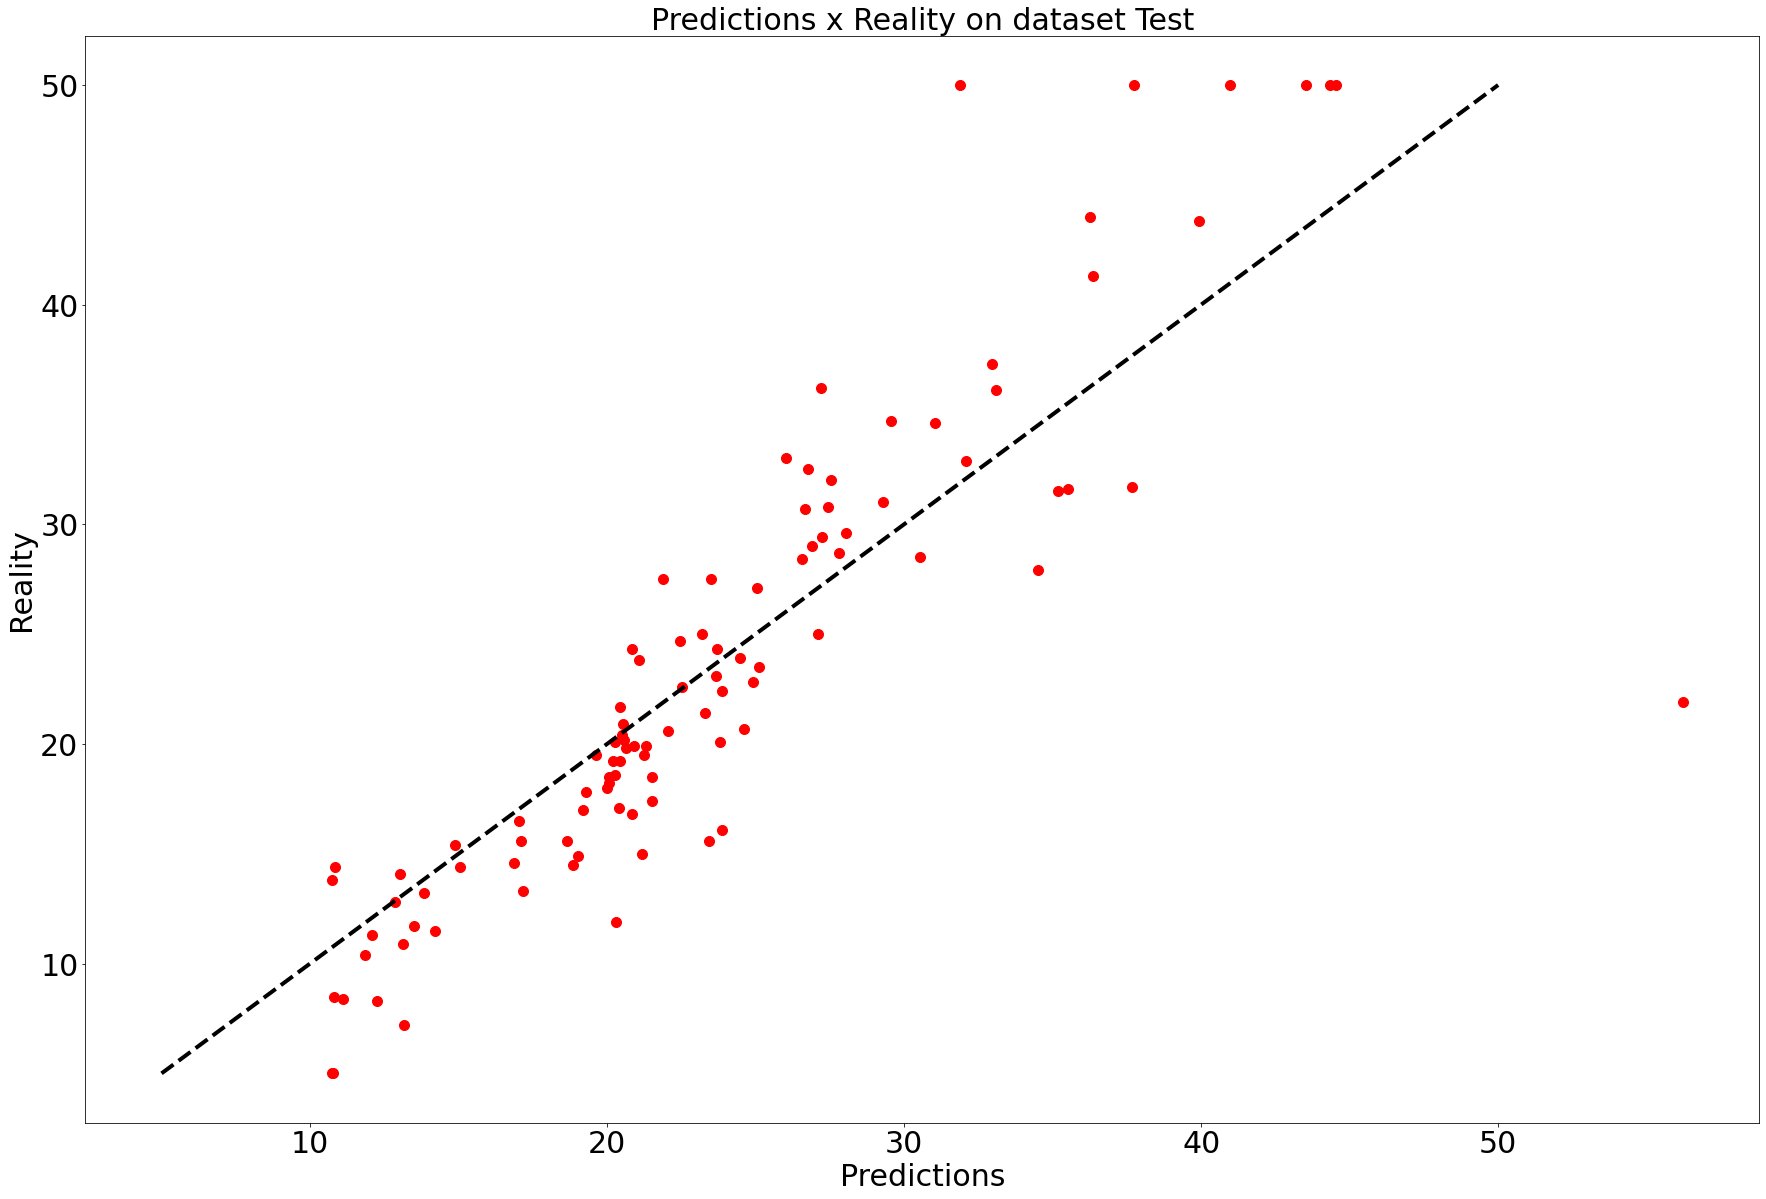

In [26]:
# 각 축의 label 사이즈를 바꾸는 과정.
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(30, 20))

# 예측 Y값(x축), 실제 Y값(y축)을 scatterplot
plt.plot(y_pred, y_test, 'ro', markersize = 10)
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

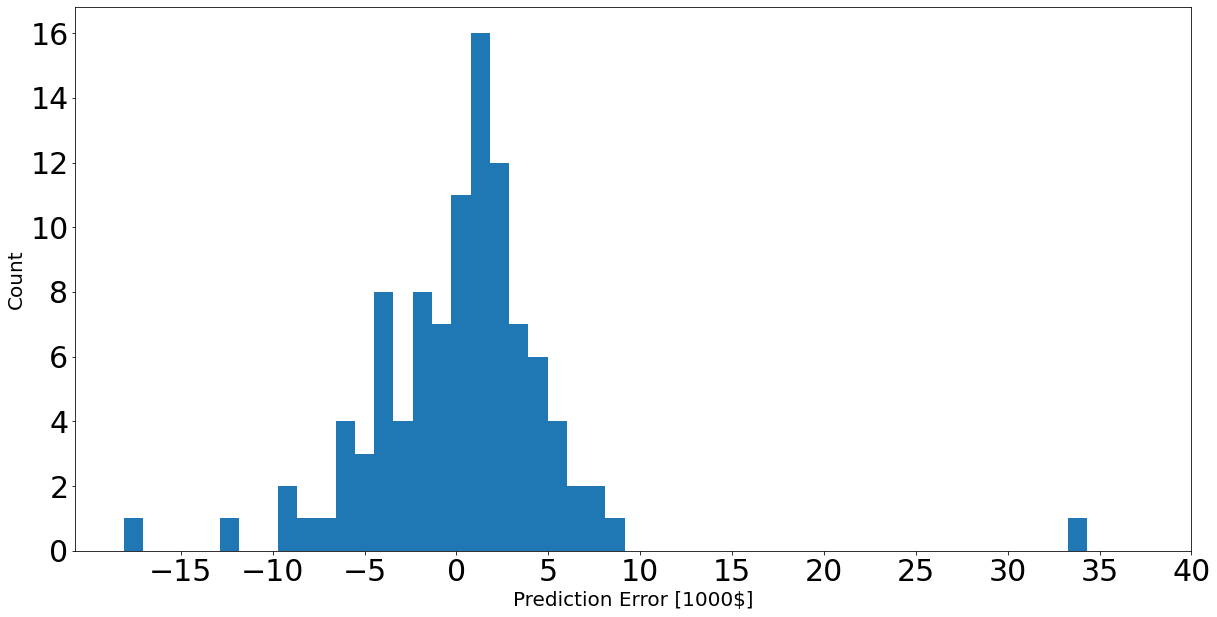

In [27]:
# 예측값 오차 히스토그램
fig, ax = plt.subplots(figsize=(20, 10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
error = y_pred - y_test
plt.hist(error, bins=50)
plt.xlabel("Prediction Error [1000$]", fontsize=20)
plt.ylabel("Count", fontsize=20)
ax.set_xticks([-15,-10,-5,0,5,10,15,20,25,30,35,40])
plt.show()